# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 06.10.2021

Мягкий дедлайн: 23:59MSK 25.10.2021

Жесткий дедлайн: 23:59MSK 28.10.2021

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import sys
import torch
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from IPython.display import clear_output

In [2]:
# Запускать только при желании смотреть за показателями по ссылочке
!pip install wandb
import wandb

wandb.init()

wandb: Currently logged in as: burunduk387 (use `wandb login --relogin` to force relogin)


In [3]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2021-10-26 22:34:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  3.10MB/s    in 2m 32s  

2021-10-26 22:37:21 (1.32 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [4]:
df = pd.read_csv("data.txt.zip", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Весь код в PEP 8 (более строгая его подвариация), надеюсь такой стиль удобен :)

In [6]:
# Для MSE/RMSE лучший константный - среднее, его и подставим
print(
    "Const_RMSE:",
    np.round(
        mean_squared_error(
            y_test, np.full(y_test.shape[0], y_test.mean()), squared=False
        ),
        4,
    ),
)
# Никто не просит честную игру для Ridge, поэтому отскейлим после него
lin_model = Ridge()
lin_model.fit(X_train, y_train)
print(
    "Ridge_RMSE:",
    np.round(mean_squared_error(y_test, lin_model.predict(X_test), squared=False), 4),
)

Const_RMSE: 10.8519
Ridge_RMSE: 9.5102


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [7]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [8]:
# Сетим сид (но это не совсем его сеттит как таковой):
set_random_seed(42)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

Отлично, я хочу кволити оф лайф импрувментс, так что прошу потерпеть и не бухтеть<br>
Всё будет хорошо по итогу :)

In [9]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [10]:
# Хочется валидационную выборку, а хочу = могу
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

In [11]:
scl = StandardScaler()
scl_true = StandardScaler()
# Скейлим X
X_train = scl.fit_transform(X_train)
X_val = scl.transform(X_val)
X_test = scl.transform(X_test)
# Скейлим y
y_train = scl_true.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
y_val = scl_true.transform(y_val.reshape(-1, 1)).reshape(-1)
y_test = scl_true.transform(y_test.reshape(-1, 1)).reshape(-1)

In [12]:
# Ладно обучим Ridge еще раз
lin_model = Ridge()
lin_model.fit(X_train, y_train)
print(
    "Ridge_RMSE:",
    np.round(
        mean_squared_error(y_test, lin_model.predict(X_test), squared=False)
        * scl_true.scale_[0],
        4,
    ),
)

Ridge_RMSE: 9.5103


In [13]:
# Делаем 3 сета
train_set = torch.utils.data.TensorDataset(
    torch.from_numpy(X_train).to(torch.float), torch.from_numpy(y_train).to(torch.float)
)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=128, shuffle=True, num_workers=0
)

valid_set = torch.utils.data.TensorDataset(
    torch.from_numpy(X_val).to(torch.float), torch.from_numpy(y_val).to(torch.float)
)
valid_loader = torch.utils.data.DataLoader(
    valid_set, batch_size=131072, shuffle=False, num_workers=0
)

test_set = torch.utils.data.TensorDataset(
    torch.from_numpy(X_test).to(torch.float), torch.from_numpy(y_test).to(torch.float)
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=131072, shuffle=False, num_workers=0
)

In [14]:
# Для некоторых экспериментов (да и в целом из-за моей лени), хочется чтобы модель могла остановиться сама
# Работает как одноимённая штука из tf
class EarlyStopping:
    """
    Early stopping to stop the training when the loss does not improve after a
    certain amount of epochs.
    """

    def __init__(self, patience=10, threshold=1e-4, verbose=False):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param threshold: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        :param verbose: printing counter value if growing
        """
        self.patience = patience
        self.threshold = threshold
        self.verbose = verbose
        self.counter = 0
        self.last_epoch = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.threshold:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.threshold:
            self.counter += 1
            if self.verbose:
                print(
                    f"Early stopping counter {self.counter} of {self.patience}, Epoch {self.last_epoch}"
                )
            if self.counter >= self.patience:
                print(f"Early stopping on Epoch {self.last_epoch}")
                self.early_stop = True
        self.last_epoch += 1

In [15]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    criterion,
    scale,
    return_losses=False,
    device="cuda:0",
):
    # Передвинем модель на выбранный ускоритель
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for obj, ans in data_loader:
            # Туда же закинем объекты и ответы
            obj = obj.to(device)
            ans = ans.to(device)
            predicted = model(obj)
            loss = criterion(predicted.view(ans.size()[0]), ans)
            # Обновим веса
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Обновим инфу
            prbar.set_description(f"Loss: {round(np.sqrt(loss.item()) * scale, 4)} ")
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
            all_losses.append(loss.detach().item() * scale)
    metrics = {"loss": np.sqrt(total_loss / num_batches) * scale}
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def valid(model, data_loader, criterion, scale, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    for obj, ans in data_loader:
        obj = obj.to(device)
        ans = ans.to(device)
        predicted = model(obj)
        loss = criterion(predicted.view(ans.size()[0]), ans)
        total_loss += loss.item()
        num_batches += 1
    metrics = {"loss": np.sqrt(total_loss / num_batches) * scale}
    return metrics


def test(model, data_loader, criterion, scale, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    for obj, ans in data_loader:
        obj = obj.to(device)
        ans = ans.to(device)
        predicted = model(obj)
        loss = criterion(predicted.view(ans.size()[0]), ans)
        total_loss += loss.item()
        num_batches += 1
    metrics = {"loss": np.sqrt(total_loss / num_batches) * scale}
    return metrics

In [16]:
def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    test_data_loader,
    optimizer,
    scheduler,
    earlystopping,
    criterion,
    scale,
    desired_loss,
    device="cuda:0",
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    epoch_test_losses = []
    for epoch in range(epochs):
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion,
            scale=scale,
            device=device,
        )
        print("loss:", np.round(train_metrics["loss"], 4), end=" ")
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # Мal step
        with torch.no_grad():
            validation_metrics = valid(
                model=model,
                data_loader=validation_data_loader,
                criterion=criterion,
                scale=scale,
                device=device,
            )
        # Save val losses
        print("val_loss:", np.round(validation_metrics["loss"], 4), end=" ")
        epoch_eval_losses.append(validation_metrics["loss"])
        # Test step
        with torch.no_grad():
            test_metrics = test(
                model=model,
                data_loader=test_data_loader,
                criterion=criterion,
                scale=scale,
                device=device,
            )
        # Save test losses
        print("test_loss:", np.round(test_metrics["loss"], 4))
        epoch_test_losses.append(test_metrics["loss"])
        scheduler.step(validation_metrics["loss"])
        earlystopping(validation_metrics["loss"])
        if earlystopping.early_stop:
            break
        # Бог мой нам разрешили делать и такие костыли:
        if test_metrics["loss"] <= desired_loss:
            break
    fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
    ax[0].plot(all_train_losses, label="Train loss")
    ax[0].set_title("Побатчевый лосс (для галочки)")
    ax[0].set_xlabel("Номер батча")
    ax[0].set_ylabel("RMSE")
    ax[0].grid()
    ax[0].legend()
    ax[1].plot(epoch_train_losses, label="Train loss")
    ax[1].plot(epoch_eval_losses, label="Validation loss")
    ax[1].plot(epoch_test_losses, label="Test loss")
    ax[1].set_title("Поэпоховый лосс")
    ax[1].set_xlabel("Эпоха")
    ax[1].set_ylabel("RMSE")
    ax[1].grid()
    ax[1].legend()
    plt.show()

In [17]:
inp_features = X_train.shape[1]

model = nn.Sequential(
    nn.Linear(inp_features, 200),
    nn.LeakyReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.2),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.BatchNorm1d(100),
    nn.Dropout(0.2),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.BatchNorm1d(50),
    nn.Linear(50, 1),
)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=10, threshold=0.0001, verbose=True
)
early_stopping = EarlyStopping(patience=20)

Train Epoch: 0



loss: 9.0477 val_loss: 8.7304 test_loss: 8.8824
Train Epoch: 1



loss: 8.8132 val_loss: 8.6555 test_loss: 8.8227
Train Epoch: 2



loss: 8.7414 val_loss: 8.6128 test_loss: 8.7748
Train Epoch: 3



loss: 8.6857 val_loss: 8.5517 test_loss: 8.7379


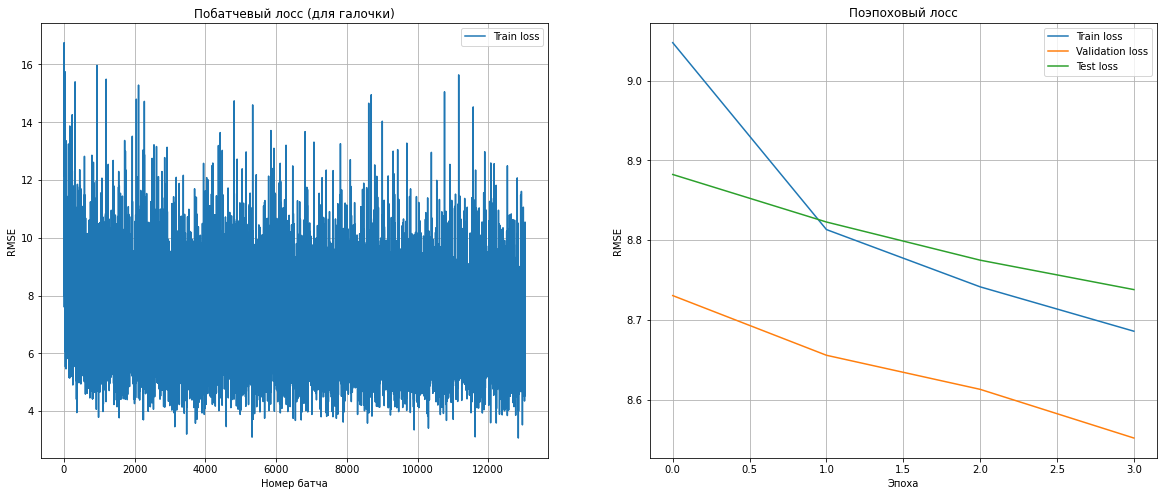

In [18]:
fit(
    model,
    1000,
    train_loader,
    valid_loader,
    test_loader,
    optimizer,
    scheduler,
    early_stopping,
    criterion,
    *scl_true.scale_,
    desired_loss=8.75,
    device=device,
)

In [19]:
test_metrics = test(
    model=model,
    data_loader=test_loader,
    criterion=criterion,
    scale=scl_true.scale_[0],
    device=device,
)
print("NN RMSE:", np.round(test_metrics["loss"], 4))

NN RMSE: 8.7379


## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Тут будет длинная повесть о моих действиях. <br>
Сначала я был не очень умный и очень хотел целочисленные предикты от модели, поэтому вызывал round от предиктов. Так я получил красивый лосс в примерно 1999 на трейне, потому что округление вызывал не совсем там где надо и сильно не так как надо. Это была моя первая ванильная нейросеть с nn.Linear(90, 1). Когда я понял, что явно делаю что-то не то и поскейлил данные и убрал округление, я получил адекватный результат около 9.52 за 10 эпох и понял, что хочется жить хорошо и оставить что-то серьезное на ночь. Так я полез читать что для этого есть, увидел про EarlyStopping в TF, успел пожалеть, что его нет в pytorch (не исключаю, что просто не нашел) и пошел реализовывать свой с помощью гугла и рук. Так я получил классную штуку на будущее. Спать уже не хотелось, поэтому я запустил на 30 эпох на сеть такого вида, начитавшись гугла на тему MLP архитектуры:<br>
nn.Linear(inp_features, 45),<br>
nn.ReLU(),<br>
nn.BatchNorm1d(45),<br>
nn.Dropout(0.15),<br>
nn.Linear(45, 1),<br>
RMSE упала до нечто похожего на 8.92 и я начал радоваться. Рано. Далее я начал экспериментировать с модельками, но уже утром следующего дня. Хотелось достичь заветных 8.77, гуглил дальше, стало понятно, что связка с релу (или лики релу), батчнормом и дропаутом в целом лучшее что есть, так что я на правильном пути. LeakyReLU я попробовал, но особой разницы не заметил вроде бы. Оставил его же. Следующий (третий уже) запомнившийся эксперимент включал как раз его:<br>
nn.Linear(inp_features, 150),<br>
nn.LeakyReLU(),<br>
nn.BatchNorm1d(150),<br>
nn.Dropout(0.1),<br>
nn.Linear(150, 50),<br>
nn.LeakyReLU(),<br>
nn.BatchNorm1d(50),<br>
nn.Dropout(0.1),<br>
nn.Linear(50, 1),<br>
Запомнился он тем, что на 6 эпохе был пробит порог и достигнуто 8.742! Дальше я просто игрался с моделькой и пытался получить  еще более крутой результат. Итогом стало:


![Result](https://i.ibb.co/ThrRt5q/image.png)

Архитектура там всё ещё выше и осталась :) Итого я вспомнил 4 эксперимета, надеюсь хватит :) Традиционный мем:

![Meme](https://habrastorage.org/webt/8a/ph/qb/8aphqb_xrv3ynavkgmuex1ib8qo.jpeg)